In [1]:
# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, TimeDistributed, Reshape, Flatten, Dropout, BatchNormalization
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import copy
from tensorflow.keras import backend as K
from sklearn import preprocessing
import tensorflow.keras.optimizers as optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

## Separate splits

In [2]:
def augument_sample(sample, averages, stds):
    return None
    
    
def format_data(df, lookback_window=12):
    x = []
    y = []
    for i in range(len(df)-lookback_window):
        x_entry = copy(df[i:i+lookback_window+1].values.T) # include current value
        x_entry[0][lookback_window] = 0.0 # erase variable to be predicted
        x.append(x_entry)
        y_entry = df['total_cases'][i+lookback_window]
        y.append(y_entry)
        
    x = np.array(x)
    y = np.array(y)
    return x, y

In [3]:
def split(x, y, train_split_size):
    train_size = int(math.ceil(len(df)*train_split_size))
    val_size = int(math.floor((len(df)*(1-train_split_size))))
    
    x_train, y_train = x[0:train_size], y[0:train_size]
    x_val, y_val = x[train_size:train_size+val_size], y[train_size:train_size+val_size]
    
    assert y_train.shape[0]+y_val.shape[0] == len(y)
    
    return x_train, y_train, x_val, y_val

## Model with Autoregressive MLP

In [4]:
def get_model(input_shape):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m =  Flatten()(m)
    m = Dense(500, activation='relu')(m)
    m = BatchNormalization()(m)
    m = Dense(200, activation='relu')(m)
    m = Dense(1, activation='relu')(m)

    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=5e-6)
    model.compile(optimizer, 'mae')
    return model

In [5]:
def train_model(model, data, epochs=200, plot=True):
    start_time = time.time()
    print('Training...')
    x_train, y_train, x_val, y_val = data
    validation_data = (x_val, y_val)
    history = model.fit(x_train, y_train, epochs=epochs,
                        verbose=False, validation_data=validation_data, batch_size=50)
    elapsed_time = time.time() - start_time
    
    print("Elapsed Time: {}".format(elapsed_time))
    
    if plot:
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.ylim(0, 40)
        plt.legend(loc='upper right')
        plt.show()
    


In [6]:
def plot_train_val(model, data):
    x_train, y_train, x_val, y_val = data
    p = model.predict(x_train)
    plt.plot(y_train, label='actual')
    plt.plot(p, label='predicted')
    plt.title('Weekly Dengue Cases')
    plt.legend()
    plt.show()

    p = model.predict(x_val)
    plt.plot(y_val, label='actual')
    plt.plot(p, label='predicted')
    plt.title('Weekly Dengue Cases')
    plt.legend()
    plt.show()
    


## Forecasting

In [7]:
def forecast(model, forecast_window, last_train, test_data):
    current = np.expand_dims(last_train, axis=0)
    next_y = model.predict(current)[0][0]
    current[0][0][-1] = next_y
    
    result = []
    for xi in test_data:
        xi[0][0:lookback_window] = current[0][0][-lookback_window:]
        current = np.expand_dims(xi, axis=0)
        next_y = model.predict(current)[0][0]
        current[0][0][-1] = next_y
        result.append(next_y)
    
    return result
    
def fake_test_data(x_val):
    x_test = copy(x_val)
    for i in x_test:
        i[0] = 0.0
    return x_test

def forecast_analysis(model, data):
    x_train, y_train, x_val, y_val = data
    x_test = fake_test_data(x_val)
    result = forecast(model, len(x_test), copy(x_train[-1]), x_test)
    error = mean_absolute_error(y_val, result)
    print("Forecast MAE: {}".format(error))

    plt.plot(result)
    plt.plot(y_val)
    plt.title('Weekly Dengue Cases')
    plt.legend(['predicted', 'actual'])
    plt.show()
    


## Load Data
- Load data from csv
- Merge dataframes
- Choose city
- Remove string columns

In [9]:
def load_data(train_split_size, lookback_window, city):
    labels = pd.read_csv('../data/dengue_labels_train.csv', parse_dates=True)
    features = pd.read_csv('../data/dengue_features_train.csv', parse_dates=True)

    all_data = pd.merge(labels, features, on=['city', 'year', 'weekofyear'])
    sj_data = all_data[all_data.city == 'sj']
    df = sj_data.drop(['city', 'week_start_date'], axis=1)

    # Move "total_cases" to column 0 to avoid bugs
    cols = list(df)
    cols.insert(0, cols.pop(cols.index('total_cases')))
    df = df.loc[:, cols]

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

In [ ]:
# x = df.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# min_max_scaler.fit(x)
# x_scaled = min_max_scaler.transform(x)
# df = pd.DataFrame(x_scaled, columns=df.columns)

## Model / Train / Forecast

## San Juan

W0928 00:19:27.508793 140148604659520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(766, 23, 171)
(766,)
(609, 23, 171)
(609,)
(157, 23, 171)
(157,)
(?, 23, 171)
Training...
Elapsed Time: 98.67466974258423


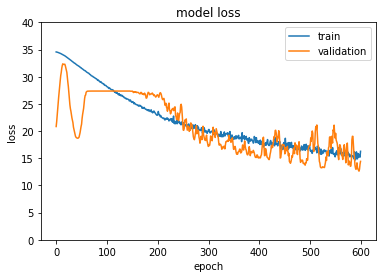

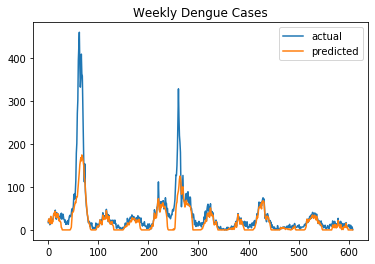

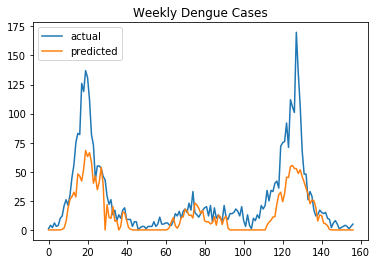

Forecast MAE: 18.491887552343357


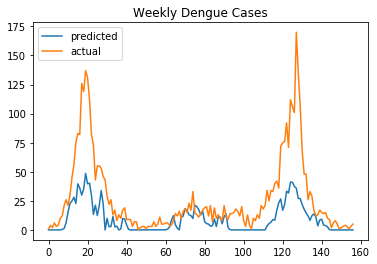

In [10]:
train_split_size = 0.65
lookback_window = 170  # weeks.
df = load_data(train_split_size, lookback_window, city='sj')


x, y = format_data(df, lookback_window)
print(x.shape)
print(y.shape)

x_train, y_train, x_val, y_val = split(x, y, train_split_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

data = x_train, y_train, x_val, y_val


K.clear_session()
input_shape = (x.shape[1], x.shape[2])
model = get_model(input_shape)
train_model(model, data, epochs=600)
plot_train_val(model, data)
forecast_analysis(model, data)

## Iquitos

(856, 23, 81)
(856,)
(609, 23, 81)
(609,)
(247, 23, 81)
(247,)
(?, 23, 81)
Training...
Elapsed Time: 56.00394415855408


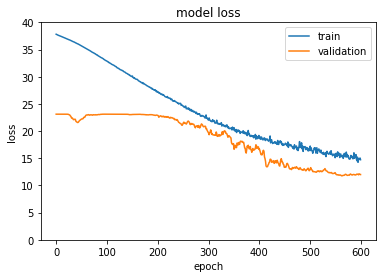

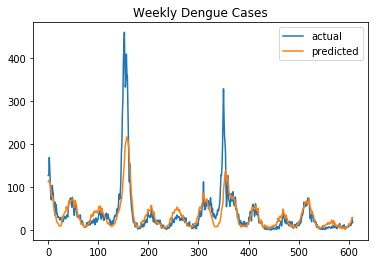

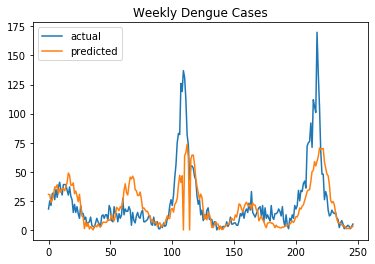

Forecast MAE: 13.99837382578174


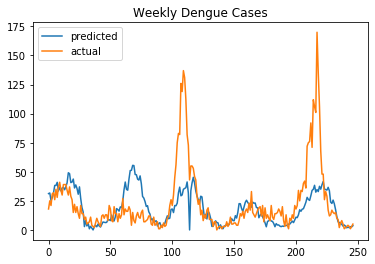

In [11]:
train_split_size = 0.65
lookback_window = 80  # weeks.
df = load_data(train_split_size, lookback_window, city='iq')

x, y = format_data(df, lookback_window)
print(x.shape)
print(y.shape)

x_train, y_train, x_val, y_val = split(x, y, train_split_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

data = x_train, y_train, x_val, y_val


K.clear_session()
input_shape = (x.shape[1], x.shape[2])
model = get_model(input_shape)
train_model(model, data, epochs=600)
plot_train_val(model, data)
forecast_analysis(model, data)

# Submission Code #TODO

In [ ]:
labels = pd.read_csv('../data/submission_format.csv', parse_dates=True)
features = pd.read_csv('../data/dengue_features_test.csv', parse_dates=True)

df_test = pd.merge(labels, features, on=['city', 'year', 'weekofyear'])